# Linear Regression

*Adapted from Chapter 3 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

# Part 1: Introduction

- **Classification problem:** supervised learning problem with a categorical response
- **Regression problem**: supervised learning problem with a continuous response
- **Linear regression:** machine learning model that can be used for regression problems

Why are we learning linear regression?

- widely used
- runs fast
- easy to use (no tuning is required)
- highly interpretable
- basis for many other methods

Lesson goals:

- Conceptual understanding of linear regression and how it "works"
- Familiarity with key terminology
- Ability to apply linear regression to a machine learning problem using scikit-learn
- Ability to interpret model coefficients
- Familiarity with different approaches for feature selection
- Understanding of three different evaluation metrics for regression
- Understanding of linear regression's strengths and weaknesses

## Libraries

- [Statsmodels](http://statsmodels.sourceforge.net/): "statistics in Python"
    - robust functionality for linear modeling
    - useful for teaching purposes
- [scikit-learn](http://scikit-learn.org/stable/): "machine learning in Python"
    - significantly more functionality for general purpose machine learning

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Reading the advertising data

In [7]:
# read data into a DataFrame
# data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
data = pd.read_csv('data/Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [8]:
data.shape

(200, 4)

What are the observations?

- Each observation represents **one market** (200 markets in the dataset)

What are the features?

- **TV:** advertising dollars spent on TV for a single product (in thousands of dollars)
- **Radio:** advertising dollars spent on Radio
- **Newspaper:** advertising dollars spent on Newspaper

What is the response?

- **Sales:** sales of a single product in a given market (in thousands of widgets)

## Questions about the data

You are asked by the company: On the basis of this data, how should we spend our advertising money in the future?

You come up with more specific questions:

1. Is there a relationship between ads and sales?
2. How strong is that relationship?
3. Which ad types contribute to sales?
4. What is the effect of each ad type of sales?
5. Given ad spending in a particular market, can sales be predicted?

## Exploring & Visualizing the data

In [9]:
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


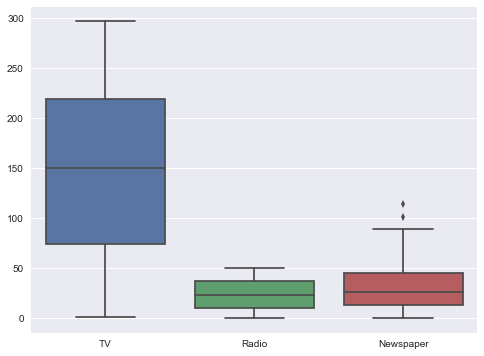

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data[["TV", "Radio", "Newspaper"]])
plt.show()

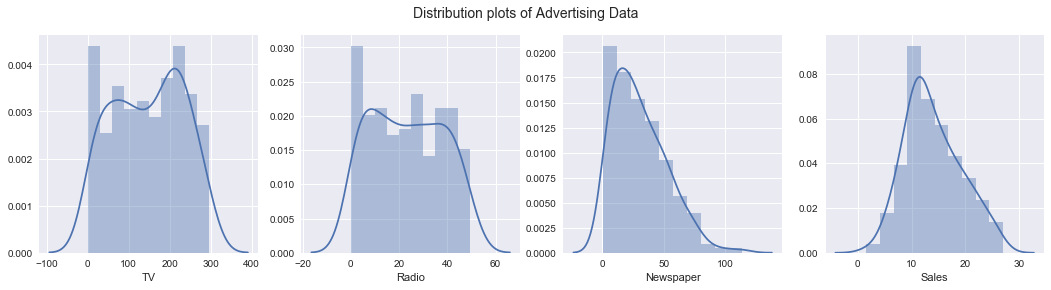

In [27]:
fig, axs = plt.subplots(1, 4, figsize=(18,4))
sns.distplot(data.TV, ax=axs[0], bins=10)
sns.distplot(data.Radio, ax=axs[1], bins=10)
sns.distplot(data.Newspaper, ax=axs[2], bins=10)
sns.distplot(data.Sales, ax=axs[3], bins=10)
fig.suptitle("Distribution plots of Advertising Data", fontsize=14)
plt.show()

Use a **scatter plot** to visualize the relationship between the features and the response.

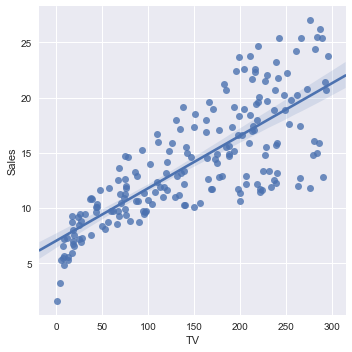

In [28]:
sns.lmplot("TV", "Sales", data)
plt.show()

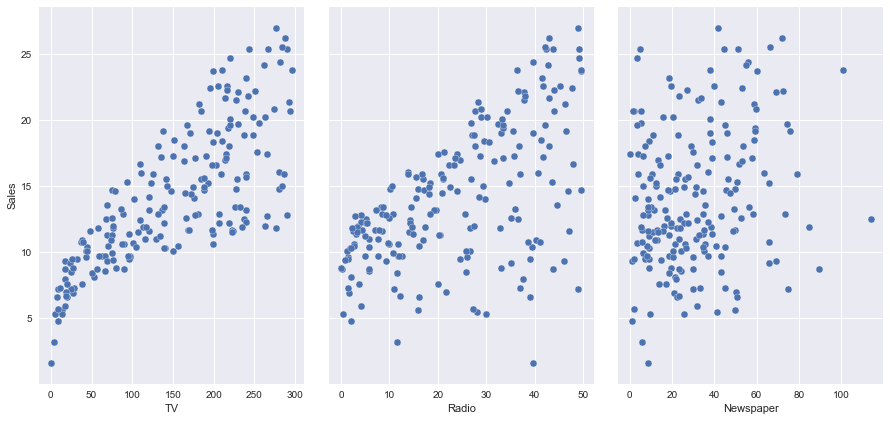

In [34]:
# scatter plot in Seaborn
sns.pairplot(data, x_vars=['TV','Radio','Newspaper'], y_vars='Sales', size=6, aspect=0.7)
plt.show()

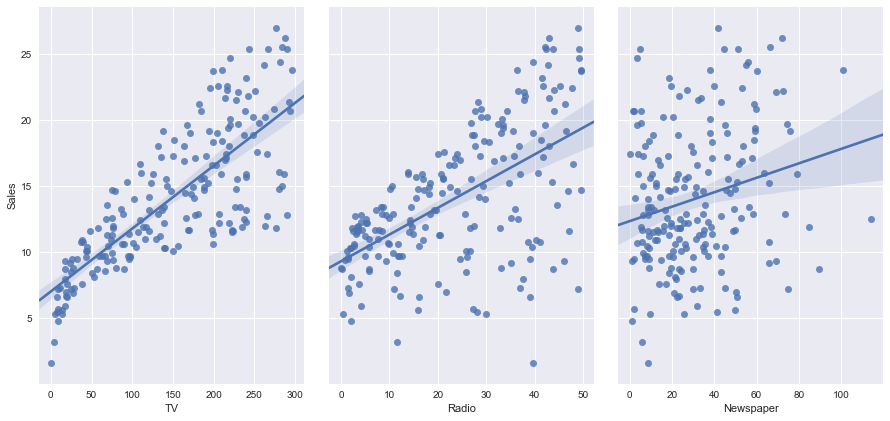

In [30]:
# include a "regression line"
sns.pairplot(data, x_vars=['TV','Radio','Newspaper'], y_vars='Sales', size=6, aspect=0.7, kind='reg')
plt.show()

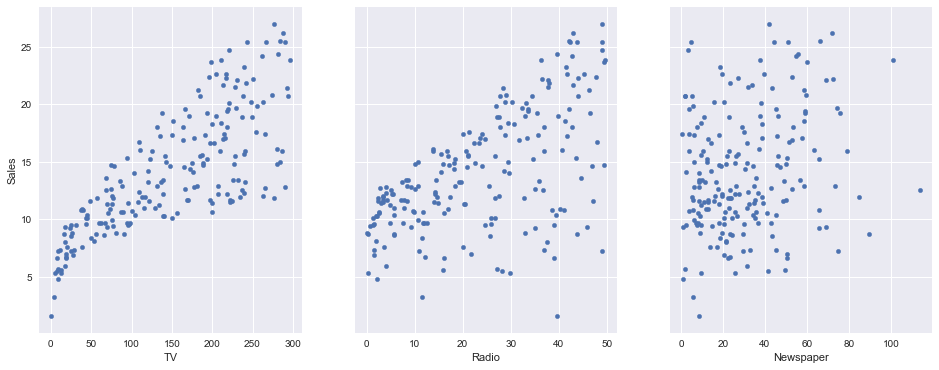

In [35]:
# scatter plot in Pandas
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
data.plot(kind='scatter', x='TV', y='Sales', ax=axs[0])
data.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2])
plt.show()

Use a **scatter matrix** to visualize the relationship between all numerical variables.

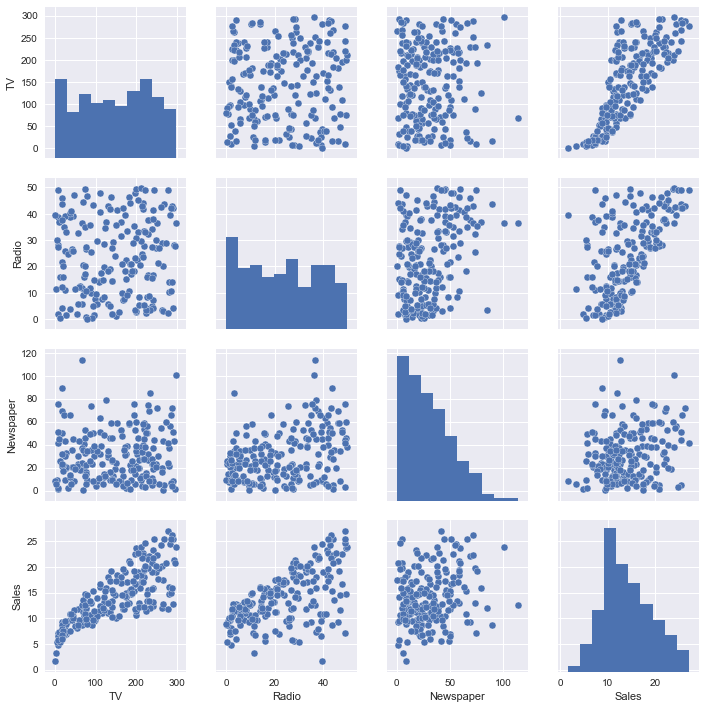

In [36]:
# scatter matrix in Seaborn
sns.pairplot(data)
plt.show()

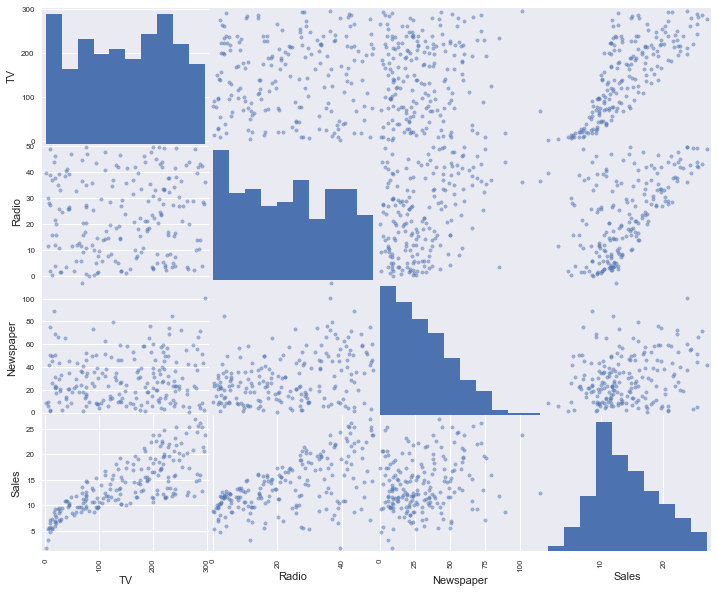

In [37]:
# scatter matrix in Pandas
pd.scatter_matrix(data, figsize=(12, 10))
plt.show()

Use a **correlation matrix** to visualize the correlation between all numerical variables.

In [38]:
# compute correlation matrix
data.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


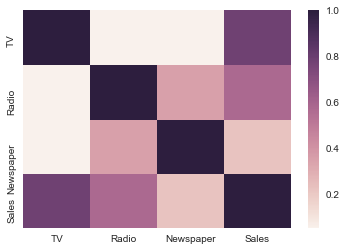

In [39]:
# display correlation matrix in Seaborn using a heatmap
sns.heatmap(data.corr())
plt.show()

You can choose the **color map** https://matplotlib.org/users/colormaps.html

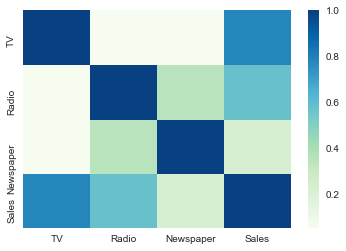

In [46]:
sns.heatmap(data.corr(), cmap="GnBu")
plt.show()

# Part 2: Simple linear regression

Simple linear regression is an approach for predicting a **continuous response** using a **single feature**. It takes the following form:

$y = \beta_0 + \beta_1x$

- $y$ is the response
- $x$ is the feature
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for x

$\beta_0$ and $\beta_1$ are called the **model coefficients**:

- We must "learn" the values of these coefficients to create our model.
- And once we've learned these coefficients, we can use the model to predict Sales.

## Estimating ("learning") model coefficients

- Coefficients are estimated during the model fitting process using the **least squares criterion**.
- We are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").

![Estimating coefficients](data/estimating_coefficients.png)

In this diagram:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the distances between the observed values and the least squares line.

![Slope-intercept](data/slope_intercept.png)

How do the model coefficients relate to the least squares line?

- $\beta_0$ is the **intercept** (the value of $y$ when $x$=0)
- $\beta_1$ is the **slope** (the change in $y$ divided by change in $x$)

Let's estimate the model coefficients for the advertising data:

In [47]:
### STATSMODELS ###

# create a fitted model
lm = smf.ols(formula='Sales ~ TV', data=data).fit()

# print the coefficients
lm.params

Intercept    7.032594
TV           0.047537
dtype: float64

In [48]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Fri, 16 Jun 2017   Prob (F-statistic):           1.47e-42
Time:                        13:39:53   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000         6.130     7.935
TV             0.0475      0.003     17.668      0.000         0.042     0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
### SCIKIT-LEARN ###

# create X and y
feature_cols = ['TV']
X = data[feature_cols]
y = data.Sales

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

7.03259354913
[ 0.04753664]


## Interpreting model coefficients

How do we interpret the TV coefficient ($\beta_1$)?

- A "unit" increase in TV ad spending is **associated with** a 0.0475 "unit" increase in Sales.
- Meaning: An additional $1,000 spent on TV ads is **associated with** an increase in sales of 47.5 widgets.
- This is not a statement of **causation**.

If an increase in TV ad spending was associated with a **decrease** in sales, $\beta_1$ would be **negative**.

## Using the model for prediction

Let's say that there was a new market where the TV advertising spend was **$50,000**. What would we predict for the Sales in that market?

$$y = \beta_0 + \beta_1x$$
$$y = 7.0326 + 0.0475 \times 50$$

In [50]:
# manually calculate the prediction
7.0326 + 0.0475*50

9.4076

In [51]:
### STATSMODELS ###

# you have to create a DataFrame since the Statsmodels formula interface expects it
X_new = pd.DataFrame({'TV': [50]})

# predict for a new observation
lm.predict(X_new)

array([ 9.40942557])

In [52]:
### SCIKIT-LEARN ###

# predict for a new observation
linreg.predict(X_new)

array([ 9.40942557])

Thus, we would predict Sales of **9,409 widgets** in that market.

## Does the scale of the features matter?

Let's say that TV was measured in dollars, rather than thousands of dollars. How would that affect the model?

In [53]:
data['TV_dollars'] = data.TV * 1000
data.head()

,TV,Radio,Newspaper,Sales,TV_dollars
1,230.1,37.8,69.2,22.1,230100.0
2,44.5,39.3,45.1,10.4,44500.0
3,17.2,45.9,69.3,9.3,17200.0
4,151.5,41.3,58.5,18.5,151500.0
5,180.8,10.8,58.4,12.9,180800.0


In [54]:
### SCIKIT-LEARN ###

# create X and y
feature_cols = ['TV_dollars']
X = data[feature_cols]
y = data.Sales

# instantiate and fit
# linreg = LinearRegression()
# linreg.fit(X, y)

linreg = LinearRegression().fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

7.03259354913
[  4.75366404e-05]


How do we interpret the TV_dollars coefficient ($\beta_1$)?

- A "unit" increase in TV ad spending is **associated with** a 0.0000475 "unit" increase in Sales.
- Meaning: An additional dollar spent on TV ads is **associated with** an increase in sales of 0.0475 widgets.
- Meaning: An additional $1,000 spent on TV ads is **associated with** an increase in sales of 47.5 widgets.

In [55]:
# predict for a new observation
linreg.predict(50000)

array([ 9.40942557])

The scale of the features is **irrelevant** for linear regression models, since it will only affect the scale of the coefficients, and we simply change our interpretation of the coefficients.

# Part 3: A deeper understanding

## Bias and variance

Linear regression is a low variance/high bias model:

- **Low variance:** Under repeated sampling from the underlying population, the line will stay roughly in the same place
- **High bias:** The line will rarely fit the data well

A closely related concept is **confidence intervals**.

## Confidence intervals

Statsmodels calculates 95% confidence intervals for our model coefficients, which are interpreted as follows: If the population from which this sample was drawn was **sampled 100 times**, approximately **95 of those confidence intervals** would contain the "true" coefficient.

In [56]:
### STATSMODELS ###

# print the confidence intervals for the model coefficients
lm.conf_int()

,0,1
Intercept,6.129719,7.935468
TV,0.042231,0.052843


- We only have a **single sample of data**, and not the **entire population of data**.
- The "true" coefficient is either within this interval or it isn't, but there's no way to actually know.
- We estimate the coefficient with the data we do have, and we show uncertainty about that estimate by giving a range that the coefficient is **probably** within.
- From Quora: [What is a confidence interval in layman's terms?](http://www.quora.com/What-is-a-confidence-interval-in-laymans-terms/answer/Michael-Hochster)

Note: 95% confidence intervals are just a convention. You can create 90% confidence intervals (which will be more narrow), 99% confidence intervals (which will be wider), or whatever intervals you like.

A closely related concept is **hypothesis testing**.

## Hypothesis testing and p-values

General process for hypothesis testing:

- You start with a **null hypothesis** and an **alternative hypothesis** (that is opposite the null).
- You check whether the data supports **rejecting the null hypothesis** or **failing to reject the null hypothesis**.

For model coefficients, here is the conventional hypothesis test:

- **null hypothesis:** There is no relationship between TV ads and Sales (and thus $\beta_1$ equals zero)
- **alternative hypothesis:** There is a relationship between TV ads and Sales (and thus $\beta_1$ is not equal to zero)

How do we test this hypothesis?

- The **p-value** is the probability that the relationship we are observing is occurring purely by chance.
[video](https://www.youtube.com/watch?v=eyknGvncKLw)
[Khan](https://www.youtube.com/watch?v=HTZ8YKgD0MI)
- If the 95% confidence interval for a coefficient **does not include zero**, the p-value will be **less than 0.05**, and we will reject the null (and thus believe the alternative).
- If the 95% confidence interval **includes zero**, the p-value will be **greater than 0.05**, and we will fail to reject the null.

In [57]:
### STATSMODELS ###

# print the p-values for the model coefficients
lm.pvalues

Intercept    1.406300e-35
TV           1.467390e-42
dtype: float64

Thus, a p-value less than 0.05 is one way to decide whether there is **likely** a relationship between the feature and the response. In this case, the p-value for TV is far less than 0.05, and so we **believe** that there is a relationship between TV ads and Sales.

Note that we generally ignore the p-value for the intercept.

## How well does the model fit the data?

R-squared:

- A common way to evaluate the overall fit of a linear model
- Defined as the **proportion of variance explained**, meaning the proportion of variance in the observed data that is explained by the model
- Also defined as the reduction in error over the **null model**, which is the model that simply predicts the mean of the observed response
- Between 0 and 1, and higher is better

Here's an example of what R-squared "looks like":

![R-squared](data/r_squared.png)

Let's calculate the R-squared value for our simple linear model:

In [58]:
### STATSMODELS ###

# print the R-squared value for the model
lm.rsquared

0.61187505085007099

In [68]:
### SCIKIT-LEARN ###

# calculate the R-squared value for the model
y_pred = linreg.predict(X)
metrics.r2_score(y, y_pred)

0.61187505085007099

- The threshold for a **"good" R-squared value** is highly dependent on the particular domain.
- R-squared is more useful as a tool for **comparing models**.

# Part 4: Multiple Linear Regression

Simple linear regression can easily be extended to include multiple features, which is called **multiple linear regression**:

$y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n$

Each $x$ represents a different feature, and each feature has its own coefficient:

$y = \beta_0 + \beta_1 \times TV + \beta_2 \times Radio + \beta_3 \times Newspaper$

In [59]:
### SCIKIT-LEARN ###

# create X and y
feature_cols = ['TV', 'Radio', 'Newspaper']
X = data[feature_cols]
y = data.Sales

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

2.93888936946
[ 0.04576465  0.18853002 -0.00103749]


In [60]:
# pair the feature names with the coefficients
zip(feature_cols, linreg.coef_)

[('TV', 0.045764645455397615),
 ('Radio', 0.18853001691820456),
 ('Newspaper', -0.0010374930424763272)]

For a given amount of Radio and Newspaper spending, an increase of $1000 in **TV** spending is associated with an **increase in Sales of 45.8 widgets**.

For a given amount of TV and Newspaper spending, an increase of $1000 in **Radio** spending is associated with an **increase in Sales of 188.5 widgets**.

For a given amount of TV and Radio spending, an increase of $1000 in **Newspaper** spending is associated with an **decrease in Sales of 1.0 widgets**. How could that be?

## Feature selection

How do I decide **which features to include** in a linear model?

### Using p-values

We could try a model with all features, and only keep features in the model if they have **small p-values**:

In [61]:
### STATSMODELS ###

# create a fitted model with all three features
lm = smf.ols(formula='Sales ~ TV + Radio + Newspaper', data=data).fit()

# print the p-values for the model coefficients
print lm.pvalues

Intercept    1.267295e-17
TV           1.509960e-81
Radio        1.505339e-54
Newspaper    8.599151e-01
dtype: float64


In [62]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Fri, 16 Jun 2017   Prob (F-statistic):           1.58e-96
Time:                        13:41:17   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000         2.324     3.554
TV             0.0458      0.001     32.809      0.000         0.043     0.049
Radio          0.1885      0.009     21.893      0.000         0.172     0.206
Newspaper     -0.0010      0.006     -0.177      0.860        -0.013     0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This indicates we would reject the null hypothesis for **TV and Radio** (that there is no association between those features and Sales), and fail to reject the null hypothesis for **Newspaper**. Thus, we would keep TV and Radio in the model.

However, this approach has **drawbacks**:

- Linear models rely upon a lot of **assumptions** (such as the features being independent), and if those assumptions are violated (which they usually are), p-values are less reliable.
- Using a p-value cutoff of 0.05 means that if you add 100 features to a model that are **pure noise**, 5 of them (on average) will still be counted as significant.

### Using R-squared

We could try models with different sets of features, and **compare their R-squared values**:

In [63]:
# R-squared value for the model with two features
lm = smf.ols(formula='Sales ~ TV + Radio', data=data).fit()
lm.rsquared

0.89719426108289557

In [64]:
# R-squared value for the model with three features
lm = smf.ols(formula='Sales ~ TV + Radio + Newspaper', data=data).fit()
lm.rsquared

0.89721063817895219

This would seem to indicate that the best model includes **all three features**. Is that right?

- R-squared will always increase as you add more features to the model, even if they are **unrelated** to the response.
- As such, using R-squared as a model evaluation metric can lead to **overfitting**.
- **Adjusted R-squared** is an alternative that penalizes model complexity (to control for overfitting), but it generally [under-penalizes complexity](http://scott.fortmann-roe.com/docs/MeasuringError.html).

As well, R-squared depends on the same assumptions as p-values, and it's less reliable if those assumptions are violated.

### Preview: Validation set and RMSE

In [65]:
# define a function that accepts X and y and computes testing RMSE
def train_test_rmse(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [66]:
# include Newspaper
feature_cols = ['TV', 'Radio', 'Newspaper']
X = data[feature_cols]
train_test_rmse(X, y)

1.404651423032895

In [67]:
# exclude Newspaper
feature_cols = ['TV', 'Radio']
X = data[feature_cols]
train_test_rmse(X, y)

1.3879034699382886

### Interaction terms 

Suppose that spending money on radio advertising actually increases the effectiveness of TV advertising, thus the slope term for TV should increase as Radio increases. In business, this is known as the synergy effect, and in statistics it is referred to as an interaction effect.

In [68]:
lm = smf.ols(formula='Sales ~ TV + Radio + Newspaper + TV*Radio', data=data).fit()

In [69]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1466.
Date:                Fri, 16 Jun 2017   Prob (F-statistic):          2.92e-144
Time:                        13:41:42   Log-Likelihood:                -270.04
No. Observations:                 200   AIC:                             550.1
Df Residuals:                     195   BIC:                             566.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.7284      0.253     26.561      0.000         6.229     7.228
TV             0.0191      0.002     12.633      0.000         0.016     0.022
Radio          0.0280      0.009      3.062      0.003         0.010     0.046
Newspaper      0.0014      0.003      0.438      0.662        -0.005     0.008
TV:Radio       0.0011   5.26e-05     20.686      0.000         0.001     0.001
==============================================================================
Omnibus:                      126.161   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1123.463
Skew:                          -2.291   Prob(JB):                    1.10e-244
Kurtosis:                      13.669   Cond. No.                     1.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Comparing linear regression with other models

Advantages of linear regression:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning methods due to high bias
- Sensitive to irrelevant features
- Can't automatically learn feature interactions